# 1. Data preprocessing

## 1.1 File Consolidation

In [1]:
import os
import re
import glob
import pandas as pd

# Target companies, keep company names in Chinese as requested
companies = ["万科A", "比亚迪", "中国石油", "贵州茅台", "中国石化"]

# Locate all yearly files
pattern = "/Users/Zhuanz1/Downloads/网络新闻量化统计（按自然日）-*.xlsx"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched pattern: {pattern}")

def extract_year(path: str):
    m = re.search(r"-(\d{4})\.xlsx$", os.path.basename(path))
    return int(m.group(1)) if m else None

# file columns
usecols = [
    "Scode", "Coname", "Date",
    "Newsnum_Title", "Newsnum_Cont",
    "Posnews_All", "Neunews_All", "Negnews_All",
    "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
]

# Read, clean, filter, and merge across files
dfs = []
for fp in files:
    df = pd.read_excel(fp, usecols=usecols, dtype={"Scode": str})

    # Drop the first "Chinese description/header" row 
    df = df[df["Coname"].notna()]
    df = df[(df["Coname"] != "公司简称") & (df["Scode"] != "股票代码")]

    # Parse date as datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].notna()]

    # Filter target companies
    df = df[df["Coname"].isin(companies)].copy()

    # Add year and source filename
    df["Year"] = extract_year(fp)
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.sort_values(["Coname", "Date"]).reset_index(drop=True)

# Output file
out_path = "/Users/Zhuanz1/Downloads/news_data.xlsx"

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    all_df.to_excel(writer, index=False, sheet_name="long")

    pivot = all_df.pivot_table(
        index="Date",
        columns="Coname",
        values=[
            "Newsnum_Title", "Newsnum_Cont",
            "Posnews_All", "Neunews_All", "Negnews_All",
            "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
        ],
        aggfunc="sum"
    )
    pivot.to_excel(writer, sheet_name="wide_pivot")

print(f"Merge completed: {out_path}")
print("Total rows:", len(all_df))
print("Years covered:", sorted(all_df["Year"].dropna().unique().tolist()))


Merge completed: /Users/Zhuanz1/Downloads/news_data.xlsx
Total rows: 21217
Years covered: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [2]:
pattern = "/Users/Zhuanz1/Downloads/*price.xlsx"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No price files found in: {pattern}")

# Target stocks
code_to_name = {
    "000002": "万科A",
    "002594": "比亚迪",
    "601857": "中国石油",
    "600519": "贵州茅台",
    "600028": "中国石化",
}
target_codes = set(code_to_name.keys())

dfs = []
for fp in files:
    df = pd.read_excel(fp, sheet_name=0)

    # Keep only rows that look like real dates
    df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
    df = df[df["TradingDate"].notna()].copy()

    # Standardize code to 6-digit string
    df["Symbol"] = df["Symbol"].astype(str).str.extract(r"(\d{6})", expand=False)

    # Filter target companies
    df = df[df["Symbol"].isin(target_codes)].copy()

    # Add company name and year
    df["Coname"] = df["Symbol"].map(code_to_name)
    df["Year"] = df["TradingDate"].dt.year
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)

# Sort by company + year + date
merged = merged.sort_values(["Coname", "Year", "TradingDate"]).reset_index(drop=True)

# Output
out_path = os.path.join(base_dir, "price_data.xlsx")
merged.to_excel(out_path, index=False)

print("Merged rows:", len(merged))
print("Saved to:", out_path)
print("Companies:", merged["Coname"].unique().tolist())
print("Years:", sorted(merged["Year"].unique().tolist()))


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_54175/1331109773.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_54175/1331109773.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil

Merged rows: 13040
Saved to: /Users/Zhuanz1/Desktop/Thesis/price_data.xlsx
Companies: ['万科A', '中国石化', '中国石油', '比亚迪', '贵州茅台']
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [8]:
# Input files
input_files = [
    "/Users/Zhuanz1/Desktop/Thesis/price_data.xlsx",
    "/Users/Zhuanz1/Desktop/Thesis/news_data.xlsx",
]

# Chinese -> English mapping
name_map = {
    "万科A": "Vanke A",
    "中国石化": "Sinopec",
    "中国石油": "PetroChina",
    "比亚迪": "BYD",
    "贵州茅台": "Kweichow Moutai",
}

# Possible company-name columns
NAME_COL_CANDIDATES = ["Coname", "name", "公司", "公司简称", "证券简称"]

def find_name_cols(columns):
    return [c for c in NAME_COL_CANDIDATES if c in columns]

for fp in input_files:
    xls = pd.ExcelFile(fp)
    out_path = os.path.splitext(fp)[0] + "_EN.xlsx"

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for sheet in xls.sheet_names:
            df = pd.read_excel(fp, sheet_name=sheet)

            # Detect name columns in this sheet
            name_cols = find_name_cols(df.columns)

            # Replace in all detected name columns
            for col in name_cols:
                df[col] = df[col].astype(str).replace(name_map)

            df.to_excel(writer, sheet_name=sheet, index=False)

    print(f"Done: {out_path}")


Done: /Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx
Done: /Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx


In [12]:
import pandas as pd

# File paths
price_path = "/Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx"
news_path  = "/Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx"
out_path   = "/Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx"

# Read files
price = pd.read_excel(price_path)
news  = pd.read_excel(news_path)

# Convert Date to datetime
price["Date"] = pd.to_datetime(price["Date"], errors="coerce")
news["Date"]  = pd.to_datetime(news["Date"], errors="coerce")

# Shift news date forward by 1 day so that news on (t-1) matches price on t
news["Date"] = news["Date"] + pd.Timedelta(days=1)

# Merge
merged = pd.merge(price, news, on=["Scode", "Date"], how="left")

# Sort and save
merged = merged.sort_values(["Scode", "Date"])
merged.to_excel(out_path, index=False)

print("Saved to:", out_path)
print("Merged rows:", len(merged))


Saved to: /Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx
Merged rows: 13040


## 1.2 Indicator Calculation

### 1.2.1 Technical Indicators

In [401]:
import pandas as pd
import numpy as np

# Read files
df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/data/price_news_merged.xlsx")
df["Date"] = pd.to_datetime(df["Date"])
df["Scode"] = df["Scode"].astype(str).str.extract(r"(\d+)", expand=False)

df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

# Parameter: (High * Low)^a in PWHLD, a = 0.5 means square root
a = 0.5
# Small constant to avoid division by zero
gamma = 1e-12

def add_factors(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    close = g["ClosePrice"]
    open_ = g["OpenPrice"]
    high = g["HighPrice"]
    low = g["LowPrice"]
    vol = g["Volume"]
    amt = g["Amount"]

    # r_t^(1) = ln(P_{t+1}) - ln(P_t)
    g["Return_1d"] = np.log(close.shift(-1)) - np.log(close)
    g["Return_5d"] = np.log(close.shift(-5)) - np.log(close)

    # Binary label (up = 1, down = 0) 
    g["y_up_1d"] = (g["Return_1d"] > 0).astype(int)
    g["y_up_5d"] = (g["Return_5d"] > 0).astype(int)
    
    # VA6DR = ((Close_t - Close_{t-6}) / Close_{t-6}) * Volume_t
    g["VA6DR"] = ((close - close.shift(6)) / (close.shift(6) + gamma)) * vol

    # UMF = (sum_{i=1..20} I(Close_{t-i} > Close_{t-i-1}) / 20) * 100
    up = (close.diff() > 0).astype(float)  # up[t] = I(Close_t > Close_{t-1})
    g["UMF"] = up.shift(1).rolling(20, min_periods=20).mean() * 100

    # PRM = (sum_{i=1..50}(High_{t-i}-Open_{t-i}) / sum_{i=1..50}(Open_{t-i}-Low_{t-i})) * 100
    num = (high - open_).shift(1).rolling(50, min_periods=50).sum()
    den = (open_ - low).shift(1).rolling(50, min_periods=50).sum()
    g["PRM"] = (num / (den + gamma)) * 100

    # PWHLD = (High_t*Low_t)^a - Amount_t/(Volume_t)
    g["PWHLD"] = (high * low) ** a - (amt / (vol + gamma))

    # 20DAMA = (1/20) * sum_{i=1..20} Amount_{t-i}
    g["20DAMA"] = amt.shift(1).rolling(20, min_periods=20).mean()

    # 5DAMA = (1/5) * sum_{i=1..5} Amount_{t-i}
    g["5DAMA"] = amt.shift(1).rolling(5, min_periods=5).mean()

    # DPA = -1 if (High-Open)(Close-Low) < (Open-Low)(High-Close), else 0
    cond = (high - open_) * (close - low) < (open_ - low) * (high - close)
    g["DPA"] = np.where(cond, -1, 0).astype(int)

    # OR = Open_t / Close_{t-1} - 1
    g["OR"] = open_ / (close.shift(1) + gamma) - 1

    # STCPC = ( (1/6) * sum_{i=1..6} Close_{t-i} ) / Close_t
    g["STCPC"] = close.shift(1).rolling(6, min_periods=6).mean() / close

    # IPM = (Close_t - Open_t) / (High_t - Low_t + gamma)
    g["IPM"] = (close - open_) / (high - low + gamma)

    # RSI - 14day
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + gamma)
    g["RSI"] = 100 - (100 / (1 + rs))

    # MACD 
    exp12 = close.ewm(span=12, adjust=False).mean()
    exp26 = close.ewm(span=26, adjust=False).mean()
    g["MACD"] = exp12 - exp26
    g["MACD_Signal"] = g["MACD"].ewm(span=9, adjust=False).mean()
    g["MACD_Hist"] = g["MACD"] - g["MACD_Signal"] # 这个差值对预测反转很有效

    # ATR 
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    g["ATR"] = tr.rolling(window=14).mean()

    # Bollinger Bands 
    ma20 = close.rolling(window=20).mean()
    std20 = close.rolling(window=20).std()
    g["Boll_Upper"] = ma20 + 2 * std20
    g["Boll_Lower"] = ma20 - 2 * std20
    g["Boll_Pos"] = (close - g["Boll_Lower"]) / (g["Boll_Upper"] - g["Boll_Lower"] + gamma)

    # ROC 
    g["ROC"] = ((close - close.shift(10)) / (close.shift(10) + gamma)) * 100
    
    g = g.dropna().copy()
    return g

out = df.groupby("Scode", group_keys=False).apply(add_factors)

# Save
out.to_excel("/Users/Zhuanz1/Desktop/Thesis/data/price_news_factors.xlsx", index=False)
print("done:", out.shape)


/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_69730/2584690596.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("Scode", group_keys=False).apply(add_factors)


done: (11513, 47)


### 1.2.2 Sentiment Indicators

In [402]:
import numpy as np
import pandas as pd

eps = 1e-12

df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/data/price_news_factors.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# ensure numeric
for c in ["Posnews_All","Neunews_All","Negnews_All","Newsnum_Cont"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

P = df["Posnews_All"]
U = df["Neunews_All"]
N = df["Negnews_All"]
T = P + U + N

df["sent_SB"]  = (P - N) / (T + eps)
df["sent_NEG"] = N / (T + eps)
df["sent_ATT"] = np.log1p(df["Newsnum_Cont"])
df["sent_HAS"] = (df["Newsnum_Cont"] > 0).astype(int)  

out_path = "/Users/Zhuanz1/Desktop/Thesis/data/price_news_sentiment.xlsx"
df.to_excel(out_path, index=False)
print("Saved:", out_path)


Saved: /Users/Zhuanz1/Desktop/Thesis/data/price_news_sentiment.xlsx


# 2. Feature Engineering

In [403]:
import pandas as pd
import numpy as np
import os

# Read file
BASE_DIR = "/Users/Zhuanz1/Desktop/Thesis/data"
input_path = os.path.join(BASE_DIR, "price_news_sentiment.xlsx")
out_path = os.path.join(BASE_DIR, "price_news_clean.xlsx")

df = pd.read_excel(input_path)

# Date parsing and sorting
date_col = "Date"  
if date_col in df.columns:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    
    # Sequence
    if "Scode" in df.columns:
        df = df.sort_values(by=["Scode", date_col])
    else:
        df = df.sort_values(by=[date_col])
        
# Fill missing Scode based on Coname
if 'Coname' in df.columns and 'Scode' in df.columns:
    mapping_df = df.dropna(subset=['Scode', 'Coname']).drop_duplicates('Coname')
    name_to_code = dict(zip(mapping_df['Coname'], mapping_df['Scode']))
    
    missing_before = df['Scode'].isna().sum()
    df['Scode'] = df['Scode'].fillna(df['Coname'].map(name_to_code))
    print(f"Scode repaired using Coname. Missing count: {missing_before} -> {df['Scode'].isna().sum()}")

# Ensure there are no rows with missing Scode
df = df.dropna(subset=['Scode'])

# Convert numeric columns
exclude_cols = [date_col, "Scode", "Coname"] 
cols_to_numeric = [c for c in df.columns if c not in exclude_cols]

for c in cols_to_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)

df[cols_to_numeric] = df[cols_to_numeric].replace([np.inf, -np.inf], np.nan)

# Remove suspended and non-trading rows
mask_valid_trade = pd.Series(True, index=df.index) 
if "Volume" in df.columns:
    mask_valid_trade &= (df["Volume"] > 0)
if "Amount" in df.columns:
    mask_valid_trade &= (df["Amount"] > 0)
if "OpenPrice" in df.columns:
    mask_valid_trade &= df["OpenPrice"].notna()

df = df[mask_valid_trade].copy()

# Missing value handling 
# Forward fill by company group to avoid filling across companies
df[cols_to_numeric] = df.groupby("Scode")[cols_to_numeric].ffill()
df[cols_to_numeric] = df[cols_to_numeric].fillna(0)

# Drop all-zero and all-empty columns
zero_cols = [c for c in cols_to_numeric if df[c].eq(0).all()]
if zero_cols:
    df = df.drop(columns=zero_cols)
    # Update the list
    cols_to_numeric = [c for c in cols_to_numeric if c not in zero_cols]
    print(f"Dropped all-zero columns: {zero_cols}")    

# Extreme value handling
# Apply log transform first
log_targets = ['Volume', 'Amount']
for col in log_targets:
    if col in df.columns:
        print(f"Applying Log1p transform to {col}...")
        df[col] = np.log1p(df[col])

unique_codes = df["Scode"].unique()
for code in unique_codes:
    # Find all rows for this company
    mask = (df["Scode"] == code)
    
    # Extract feature data
    subset = df.loc[mask, cols_to_numeric]
    
    # Compute quantiles (1% and 99%)
    low = subset.quantile(0.01)
    high = subset.quantile(0.99)
    
    # Clip and assign back
    df.loc[mask, cols_to_numeric] = subset.clip(lower=low, upper=high, axis=1)

# Save
df.to_excel(out_path, index=False)
print(f"Saved to: {out_path}")
print(f"Final shape: {df.shape}")
print(df[cols_to_numeric].head())


Scode repaired using Coname. Missing count: 0 -> 0
Applying Log1p transform to Volume...
Applying Log1p transform to Amount...
Saved to: /Users/Zhuanz1/Desktop/Thesis/data/price_news_clean.xlsx
Final shape: (11513, 48)
   OpenPrice  ClosePrice  HighPrice  LowPrice     Volume     Amount  \
0  722.34452   727.85052  734.83868  711.4609  19.157784  21.195242   
1  722.34452   727.85052  734.83868  711.4609  18.821039  20.862944   
2  722.34452   727.85052  734.83868  711.4609  18.685434  20.719472   
3  722.34452   727.85052  734.83868  711.4609  18.583717  20.627078   
4  722.34452   727.85052  734.83868  711.4609  18.250959  20.281158   

    AvgPrice  ChangeRatio    TotalShare  TurnoverRate1  ...  MACD_Hist  \
0  722.21956      0.01333  1.101497e+10        0.01897  ...   8.959309   
1  722.21956      0.01447  1.101497e+10        0.01355  ...  10.359211   
2  722.21956     -0.02335  1.101497e+10        0.01183  ...   9.706860   
3  722.21956      0.03054  1.101497e+10        0.01069  ..

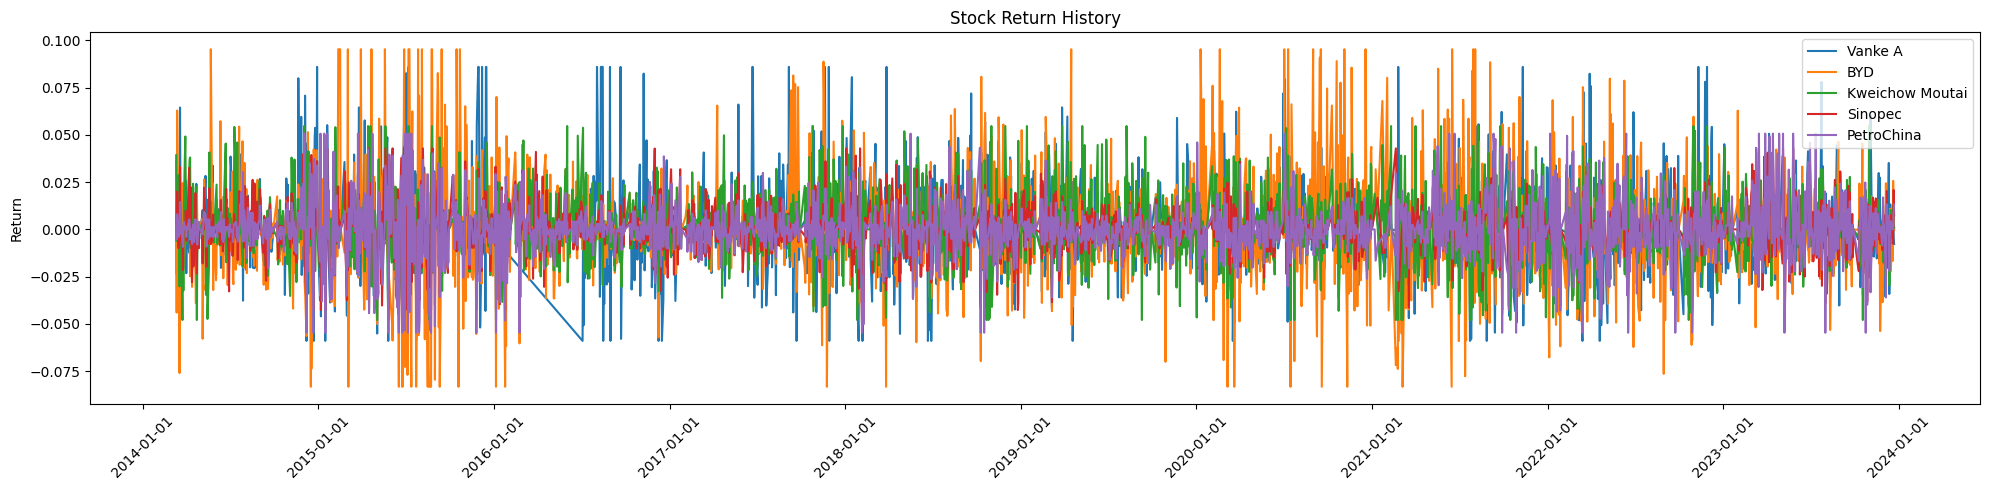

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/data/price_news_clean.xlsx")
names = ["Vanke A", "BYD", "Kweichow Moutai","Sinopec","PetroChina"] 

fig, ax = plt.subplots(figsize=(20, 5))
for name in names:
    tmp = df[df["Coname"] == name].dropna(subset=["Date", "Return_1d"]).sort_values("Date")
    ax.plot(tmp["Date"], tmp["Return_1d"], label=name)

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.set_title("Stock Return History")
ax.set_ylabel("Return")
plt.xticks(rotation=45)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [251]:
df["Scode"] = df["Scode"].astype(str).str.extract(r"(\d{6})", expand=False)
df["y_up_1d"] = pd.to_numeric(df["y_up_1d"], errors="coerce")
df = df.dropna(subset=["y_up_1d"]).copy()

feature_cols = [
    "OpenPrice","ClosePrice","HighPrice","LowPrice",
    "Volume","ChangeRatio",
    "VA6DR","UMF","PRM","PWHLD","20DAMA","5DAMA","DPA","OR","STCPC","IPM",
    "RSI", "MACD", "MACD_Signal", "MACD_Hist", "ATR", 
    "Boll_Upper", "Boll_Lower", "Boll_Pos", "ROC",
    "sent_SB","sent_NEG","sent_ATT","sent_HAS"
]

missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=feature_cols).copy()


In [252]:
# split by date 
TRAIN_END = pd.Timestamp("2020-12-31")
VAL_END   = pd.Timestamp("2022-12-31")

train_df = df[df["Date"] <= TRAIN_END].copy()
val_df   = df[(df["Date"] > TRAIN_END) & (df["Date"] <= VAL_END)].copy()
test_df  = df[df["Date"] > VAL_END].copy()

In [253]:
import numpy as np
from sklearn.preprocessing import StandardScaler

for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    df[feature_cols] = df[feature_cols].astype('float64')
    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    df[feature_cols] = df[feature_cols].fillna(0)

# Per-Company Standardization
scalers = {}
unique_codes = train_df["Scode"].dropna().unique()

for code in unique_codes:
    train_mask = (train_df["Scode"] == code)
    val_mask   = (val_df["Scode"] == code)
    test_mask  = (test_df["Scode"] == code)
    
    # Initialize scaler
    sc = StandardScaler()
    
    # Compute mean and variance on the training set only
    train_data = train_df.loc[train_mask, feature_cols].values
    sc.fit(train_data)
    
    scalers[code] = sc
    
    # Transform train/val/test
    train_df.loc[train_mask, feature_cols] = sc.transform(train_data) 
    if val_mask.any():
        val_df.loc[val_mask, feature_cols] = sc.transform(val_df.loc[val_mask, feature_cols].values)  
    if test_mask.any():
        test_df.loc[test_mask, feature_cols] = sc.transform(test_df.loc[test_mask, feature_cols].values)

# Verification
print(">>> Standardization Complete. Verifying results...")
for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    data = df[feature_cols].values
    is_clean = np.isfinite(data).all()
    mean_val = np.mean(data)
    std_val = np.std(data)
    
    print(f"[{name}] Clean: {is_clean} | Mean: {mean_val:.4f} | Std: {std_val:.4f}")
    
    if not is_clean:
        raise ValueError(f"Error: {name} dataset still contains NaN or Inf!")

print("Ready for model training.")


>>> Standardization Complete. Verifying results...
[Train] Clean: True | Mean: 36213178.0952 | Std: 322525994.0459
[Val] Clean: True | Mean: 105748167.8203 | Std: 762302706.8901
[Test] Clean: True | Mean: 51969704.8889 | Std: 348086557.7058
Ready for model training.


In [254]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# build windows 
def make_windows(df_part, feature_cols, lag):
    X_list, y_list = [], []

    for scode, g in df_part.groupby("Scode"):
        g = g.sort_values("Date").reset_index(drop=True)
        if len(g) < lag:
            continue

        Xg = g[feature_cols].values.astype(np.float32)  
        yg = g["y_up_1d"].values.astype(np.int64)      
        
        for end in range(lag - 1, len(g)):
            start = end - lag + 1
            X_list.append(Xg[start:end + 1])           
            y_list.append(yg[end])                                   

    if len(X_list) == 0:
        X = torch.empty((0, lag, len(feature_cols)), dtype=torch.float32)
        y = torch.empty((0,), dtype=torch.float32)
        return TensorDataset(X, y)

    X = torch.from_numpy(np.stack(X_list)).float()              # (B, lag, F)
    y = torch.from_numpy(np.array(y_list)).long()               # (B,)

    return TensorDataset(X, y)

lag = 5
train_set = make_windows(train_df, feature_cols, lag)
val_set   = make_windows(val_df, feature_cols, lag)
test_set  = make_windows(test_df, feature_cols, lag)

print("Train/Val/Test:", len(train_set), len(val_set), len(test_set))

if len(train_set) > 0:
    print("One sample:", train_set[0][0].shape, train_set[0][1].shape)
else:
    print("train_set is empty")

Train/Val/Test: 4877 1350 687
One sample: torch.Size([5, 29]) torch.Size([])


In [255]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

# 3. Intra-modal feature extraction

## 3.1 Price modality: the LSTM encoder extracts temporal features

In [256]:
price_cols = [
    "OpenPrice","ClosePrice","HighPrice","LowPrice",
    "Volume","ChangeRatio",
    "VA6DR","UMF","PRM","PWHLD","20DAMA","5DAMA","DPA","OR","STCPC","IPM",
     "RSI", "MACD", "MACD_Signal", "MACD_Hist", "ATR", 
    "Boll_Upper", "Boll_Lower", "Boll_Pos", "ROC"
]

news_cols = ["sent_SB","sent_NEG","sent_ATT","sent_HAS"]

n_price = len(price_cols)
n_news  = len(news_cols)

class PriceLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=1, 
        )

    def forward(self, x_price):
        """
        x_price: (B, L, D_price)
        return:  (B, hidden_dim)
        """
        out, (h_n, c_n) = self.lstm(x_price)
        h_price = h_n[-1]   # (B, hidden_dim)
        return h_price

## 3.2 News modality: the MLP encoder extracts a nonlinear sentiment representation

In [257]:
class NewsMLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, out_dim=32, dropout=0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x_news):
        B, L, D = x_news.shape
        z = self.mlp(x_news.reshape(B * L, D))     # (B*L, out_dim)
        z = z.view(B, L, -1)                   # (B, L, out_dim)
        h_news = z.mean(dim=1)                    # (B, out_dim)  mean pooling
        return h_news

# 4.Early Fusion Predictor

In [258]:
class EarlyFusionPredictor(nn.Module):
    """
    input: X = (B, L, D_total) where D_total = n_price + n_news
    slicing: X[..., :n_price] -> x_price
             X[..., n_price:] -> x_news
    fusion: concat(h_price, h_news) -> MLP -> output
    """
    def __init__(self, n_price, n_news, price_hidden_dim=32, news_out_dim=32, fusion_hidden_dim=32, dropout=0.5):
        super().__init__()
        self.n_price = n_price
        self.n_news  = n_news

        self.price_encoder = PriceLSTMEncoder(input_dim=n_price,hidden_dim=price_hidden_dim)
        self.news_encoder = NewsMLPEncoder(input_dim=n_news,hidden_dim=16,out_dim=news_out_dim,dropout=dropout)

        fusion_in_dim = price_hidden_dim + news_out_dim
        self.norm = nn.LayerNorm(fusion_in_dim) 

        self.head = nn.Sequential(
            nn.Linear(fusion_in_dim, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden_dim, 2)  
        )

    def forward(self, X):
        # X: (B, L, n_price+n_news)
        x_price = X[..., :self.n_price]           # (B, L, n_price)
        x_news  = X[..., self.n_price:self.n_price+self.n_news]  # (B, L, n_news)

        h_price = self.price_encoder(x_price)     # (B, price_hidden_dim)
        h_news  = self.news_encoder(x_news)       # (B, news_out_dim)

        h = torch.cat([h_price, h_news], dim=-1)  # early fusion
        h = self.norm(h)
        return self.head(h)                       # (B, out_dim)


In [259]:
class MidFusionPredictor(nn.Module):
    """
    Mid-level fusion with Cross-Attention (price as Q, news as K/V):
    1) price -> LSTM -> Hp_seq: (B,L,Hp)
    2) news  -> MLP  -> Hn_seq: (B,L,Hn)
    3) Project to the same dimension d_model, X: (B, L, Dtotal), Dtotal = n_price + n_news
    4) Q = proj(price), K/V = news
    5) CrossAttention: attn_out = MHA(Q=price, K=news, V=news) -> (B,L,d_model)
    6) Residual + LayerNorm, then sequence aggregation to (B,*): mean pooling
    7) head -> logits (B,1)
    """
    def __init__(
        self, n_price, n_news,
        price_hidden_dim = 32, news_hidden_dim = 16,
        d_model = 32, num_heads = 4, dropout = 0.5,
    ):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.n_price = n_price
        self.n_news  = n_news
        
        # Intermediate representations of the two modalities
        self.price_seq = nn.LSTM(n_price, price_hidden_dim, batch_first=True)
        self.news_seq  = nn.Sequential(
            nn.Linear(n_news, news_hidden_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout), 
            nn.Linear(news_hidden_dim, d_model)
        )
        # Map price Hp to d_model to ensure Q, K, V have the same dimension
        self.price_proj = nn.Linear(price_hidden_dim, d_model)

        # Cross-Attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.attn_drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.head = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(d_model, 2)
        )


    def forward(self, X):
        # X: (B,L,Dtotal) where Dtotal = n_price + n_news
        x_price = X[..., :self.n_price]  # (B,L,n_price)
        x_news  = X[..., self.n_price:self.n_price + self.n_news]  # (B,L,n_news)

        # Encoding
        hp_seq, _ = self.price_seq(x_price)          # (B,L,Hp)
        B, L, Dn = x_news.shape
        hn_seq = self.news_seq(x_news.reshape(-1, Dn)).reshape(B, L, -1)            # (B,L,d_model)

        q = self.price_proj(hp_seq)               # (B,L,d_model)
        k = hn_seq                                # (B,L,d_model)
        v = hn_seq                                # (B,L,d_model)

        # Cross-Attention
        attn_out, _ = self.cross_attn(q, k, v)    # (B,L,d_model)

        # Residual fusion + normalization
        h = self.norm1(q + self.attn_drop(attn_out))  # (B,L,d_model)
        # Pooling
        z = h.mean(dim=1)           # (B,d_model)
        z = self.norm2(z)

        return self.head(z)         # (B,2)


In [260]:
import torch
import torch.nn as nn

# Price branch: use only price features to output price_logit
class PriceOnlyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 2)  
        )

    def forward(self, x_price):
        # x_price: (B,L,Dp)
        _, (h_n, _) = self.lstm(x_price)
        h = h_n[-1]                # (B,hidden_dim)
        return self.head(h)        # (B,2) price_logit


# News branch: use only news features to output news_logit 
class NewsOnlyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, out_dim=16, dropout=0.5):
        super().__init__()
        self.step_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, 2) 
        )

    def forward(self, x_news):
        # x_news: (B,L,Dn)
        B, L, D = x_news.shape
        z = self.step_mlp(x_news.contiguous().view(B * L, D))  # (B*L,out_dim)
        z = z.reshape(B, L, -1)                      # (B,L,out_dim)
        h = z.mean(dim=1)                            # (B,out_dim) mean pooling over time first
        return self.head(h)                          # (B,1) news_logit


# Late fusion: fuse the two branches' "prediction outputs" 
class LateFusionPredictor(nn.Module):
    """
    Weighted late fusion on logits:
    final_logits = w0 * price_logits + w1 * news_logits + b
    where w = softmax([w0_raw, w1_raw]).
    """
    def __init__(self, n_price, n_news, price_hidden=32, news_hidden=16, news_out=16, dropout=0.5):
        super().__init__()

        self.n_price = n_price
        self.n_news = n_news

        self.price_model = PriceOnlyPredictor(input_dim=n_price, hidden_dim=price_hidden)
        self.news_model  = NewsOnlyPredictor(input_dim=n_news, hidden_dim=news_hidden, out_dim=news_out, dropout=dropout)

        # Modality weights (raw); transformed by softmax during training to be positive and sum to 1
        self.w = nn.Parameter(torch.tensor([0.0, 0.0], dtype=torch.float32))  # initial softmax is [0.5, 0.5]
        # One bias per class
        self.b = nn.Parameter(torch.zeros(2, dtype=torch.float32))


    def forward(self, X):
        # X: (B,L,Dtotal)
        x_price = X[..., :self.n_price]
        x_news  = X[..., self.n_price:self.n_price+self.n_news]

        price_logit = self.price_model(x_price)  
        news_logit  = self.news_model(x_news)     

        w = torch.softmax(self.w, dim=0)         
        final_logits = w[0] * price_logit + w[1] * news_logit + self.b  
        return final_logits


In [261]:
def Loss_function(train_set, device):
    y = train_set.tensors[1].long()
    pos = (y == 1).sum().item()
    neg = (y == 0).sum().item()
    if pos > 0 and neg > 0:
        w = torch.tensor([1.0, neg / pos], dtype=torch.float32, device=device)
        return nn.CrossEntropyLoss(weight=w)
    return nn.CrossEntropyLoss()
    
def train_one_epoch(model, loader, optimizer, criterion, device, clip_norm=1.0):
    model.train()
    total_loss, total_n = 0.0, 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device).long()

        optimizer.zero_grad()
        logits = model(X)              
        loss = criterion(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / total_n

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss, total_n = 0.0, 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device).long()
        logits = model(X)              # (B,2)
        loss = criterion(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / total_n
    

In [262]:
import copy
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

@torch.no_grad()
def collect_probs(model, loader, device):
    model.eval()
    y_true_list, y_prob_list = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)                          
        probs = torch.softmax(logits, dim=1)[:, 1] 
        
        y_true_list.append(y.detach().cpu().numpy())
        y_prob_list.append(probs.detach().cpu().numpy())
        
    y_true = np.concatenate(y_true_list).astype(int)
    y_prob = np.concatenate(y_prob_list).astype(float)
    return y_true, y_prob

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred, labels=[0, 1])
    auc  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) >= 2 else np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc, "cm": cm}
    
def train_select(
    model_name,
    model,
    train_set,
    train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=0.5,
    clip_norm=1.0, patience=15, device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = Loss_function(train_set, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2) 

    best_val_loss = float("inf")
    best_state = None
    history = []

    # Early Stopping Variables
    patience_counter = 0
    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, clip_norm=clip_norm)
        va_loss = eval_loss(model, val_loader, criterion, device)

        # Check for improvement
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0  # Reset counter if improvement found
        else:
            patience_counter += 1 # Increment counter if no improvement

        history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
        print(f"[{model_name}] Epoch {epoch:02d} | Train {tr_loss:.4f} | Val {va_loss:.4f} | BestVal {best_val_loss:.4f}")

        # Check Early Stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}!")
            break
    if best_state is not None:
        model.load_state_dict(best_state)

    # best val loss
    yv_true, yv_prob = collect_probs(model, val_loader, device)
    yt_true, yt_prob = collect_probs(model, test_loader, device)

    val_metrics = compute_metrics(yv_true, yv_prob, threshold=threshold)
    test_metrics = compute_metrics(yt_true, yt_prob, threshold=threshold)

    return model, pd.DataFrame(history), best_val_loss, val_metrics, test_metrics


In [263]:
def run_models(
    n_price, n_news,
    train_set, train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=0.5, patience=15, device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = {
        "Early": EarlyFusionPredictor(
            n_price, n_news, 
            price_hidden_dim=32, news_out_dim=32, fusion_hidden_dim=32, 
            dropout=0.5
        ),
        "Mid": MidFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden_dim=32, news_hidden_dim=16, 
            d_model=32, num_heads=4, 
            dropout=0.5
        ),
        "Late": LateFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden=32, news_hidden=16, news_out=16, 
            dropout=0.5
        ),
    }

    results = []
    trained_models = {}
    histories = {}

    for name, model in models.items():
        print("\n" + "="*60)
        print(f"Training {name} (select best by min val loss)")
        print("="*60)

        trained_model, hist_df, best_val_loss, val_m, test_m = train_select(
            model_name=name,
            model=model,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            threshold=threshold,
            patience=patience,
            device=device
        )

        trained_models[name] = trained_model
        histories[name] = hist_df

        results.append({
            "model": name,
            "best_val_loss": best_val_loss,
            "val": val_m,
            "test": test_m
        })

    # result
    rows = []
    for r in results:
        for split in ["val", "test"]:
            m = r[split]
            cm = m["cm"]
            tn, fp = cm[0, 0], cm[0, 1]
            fn, tp = cm[1, 0], cm[1, 1]
            rows.append({
                "model": r["model"],
                "split": split,
                "best_val_loss": r["best_val_loss"],
                "acc": m["acc"],
                "prec": m["prec"],
                "rec": m["rec"],
                "f1": m["f1"],
                "auc": m["auc"],
                "tn": tn, "fp": fp, "fn": fn, "tp": tp
            })
    df = pd.DataFrame(rows).sort_values(["split", "f1"], ascending=[True, False]).reset_index(drop=True)
    df_test = df[df["split"] == "test"].sort_values("f1", ascending=False).reset_index(drop=True)

    return results, df, df_test, trained_models, histories


In [264]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results, df_results, df_test, trained_models, histories = run_models(
    n_price=n_price,
    n_news=n_news,
    train_set=train_set,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=100,
    lr=1e-4,
    threshold=0.5,
    patience=15,
    device=device
)



Training Early (select best by min val loss)
[Early] Epoch 01 | Train 0.7072 | Val 0.6963 | BestVal 0.6963
[Early] Epoch 02 | Train 0.7029 | Val 0.6960 | BestVal 0.6960
[Early] Epoch 03 | Train 0.6991 | Val 0.6959 | BestVal 0.6959
[Early] Epoch 04 | Train 0.6970 | Val 0.6960 | BestVal 0.6959
[Early] Epoch 05 | Train 0.6960 | Val 0.6960 | BestVal 0.6959
[Early] Epoch 06 | Train 0.6960 | Val 0.6963 | BestVal 0.6959
[Early] Epoch 07 | Train 0.6965 | Val 0.6960 | BestVal 0.6959
[Early] Epoch 08 | Train 0.6948 | Val 0.6956 | BestVal 0.6956
[Early] Epoch 09 | Train 0.6927 | Val 0.6953 | BestVal 0.6953
[Early] Epoch 10 | Train 0.6922 | Val 0.6954 | BestVal 0.6953
[Early] Epoch 11 | Train 0.6923 | Val 0.6953 | BestVal 0.6953
[Early] Epoch 12 | Train 0.6920 | Val 0.6953 | BestVal 0.6953
[Early] Epoch 13 | Train 0.6928 | Val 0.6953 | BestVal 0.6953
[Early] Epoch 14 | Train 0.6911 | Val 0.6954 | BestVal 0.6953
[Early] Epoch 15 | Train 0.6904 | Val 0.6954 | BestVal 0.6953
[Early] Epoch 16 | Train

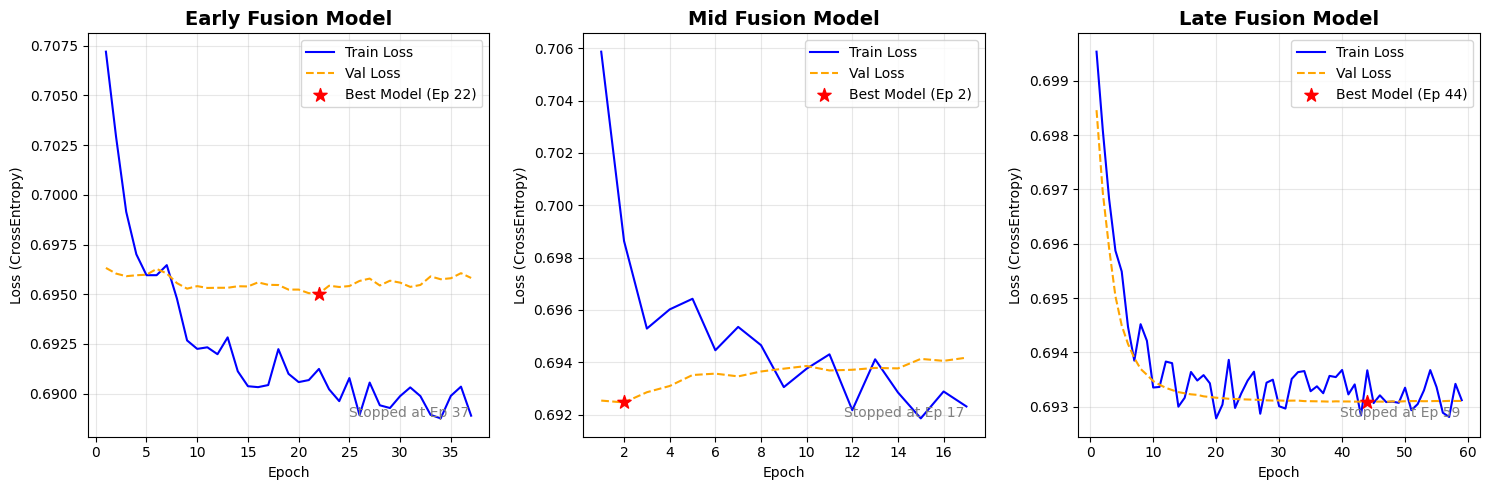

In [265]:
import matplotlib.pyplot as plt
import math

def plot_loss_curves(histories):
    n_models = len(histories)
    cols = n_models
    rows = 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5), sharey=False)

    for ax, (name, df) in zip(axes, histories.items()):
        ax.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue', linestyle='-')
        ax.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange', linestyle='--')
        
        # 标记出最佳点 
        best_row = df.loc[df['val_loss'].idxmin()]
        best_epoch = best_row['epoch']
        best_val = best_row['val_loss']
        
        ax.scatter(best_epoch, best_val, color='red', s=100, marker='*', zorder=5, 
                   label=f'Best Model (Ep {int(best_epoch)})')
        
        # 图表装饰
        ax.set_title(f"{name} Fusion Model", fontsize=14, fontweight='bold')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss (CrossEntropy)")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 标注早停信息
        final_epoch = df['epoch'].iloc[-1]
        ax.text(0.95, 0.05, f"Stopped at Ep {final_epoch}", 
                transform=ax.transAxes, ha='right', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

plot_loss_curves(histories)

In [266]:
df_test

,model,split,best_val_loss,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,Mid,test,0.692465,0.470160,0.457317,0.698758,0.552826,0.478261,98,267,97,225
1,Early,test,0.695031,0.510917,0.481183,0.555901,0.515850,0.540543,172,193,143,179
2,Late,test,0.693093,0.531295,0.000000,0.000000,0.000000,0.526376,365,0,322,0


In [245]:
df_results

,model,split,best_val_loss,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,Mid,test,0.688673,0.471963,0.495430,0.811377,0.615210,0.391360,32,276,63,271
1,Early,test,0.694897,0.506231,0.532819,0.413174,0.465430,0.510625,187,121,196,138
2,Late,test,0.693131,0.479751,0.000000,0.000000,0.000000,0.390043,308,0,334,0
3,Mid,val,0.688673,0.543295,0.541364,0.571210,0.555887,0.555532,336,316,280,373
4,Early,val,0.694897,0.497318,0.497689,0.494640,0.496160,0.503389,326,326,330,323
5,Late,val,0.693131,0.499617,0.000000,0.000000,0.000000,0.479508,652,0,653,0
